# Hotel reservation Dataset

<img src='https://www.entergraph.com/wp-content/uploads/2013/11/Hotel-Booking-web-sites-in-Thailand.jpg'>

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
Welcome to my Jupyter notebook! In this notebook, we will explore a hotel booking dataset and we want to predict cancellations using various machine learning (ML) algorithms (i.e.  XGBoost, decision tree, K-nearest neighbors (KNN), random forest , ...). The notebook will start by loading and preprocessing the dataset, ensuring that it is ready for analysis. Various visualizations will be performed to gain insights into the dataset. 
Next, the ML algorithms will be implemented and trained on the dataset and optimal hyperparameters are derived through the grid search. Each algorithm will be evaluated based on its performance metrics, such as accuracy and F1-score. These metrics will provide an understanding of how well each algorithm predicts cancellations.These insights can help stakeholders in making informed decisions and developing strategies to mitigate cancellations.
Please note that "xgboost" and "folium" libraries are installed before you start running the notebook. (remove "#" sign in the first two lines of the following cells if they are not installed.)

In [1]:
#!pip install folium
#!pip install -U xgboost
import folium
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import pickle

from sklearn.base import TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer    
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV  
import xgboost as xgb 
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("hotel_booking.csv")

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
<p> 
The features in the dataset are as follows:

1. hotel : Resort Hotel or City Hotel. 
2. is_canceled Value: showing if the booking had been cancelled (1) or not (0).
3. lead_time: Number of days that elapsed between the entering date of the booking into the PMS and the arrival date.
4. arrival_date_year: Year of arrival date. 
5. arrival_date_month: The months in which guests are coming. 
6. arrival_date_week_number: Week number of year for arrival date. 
7. arrival_date_day_of_month: Which day of the months guest is arriving. 
8. stays_in_weekend_nights: Number of weekend stay at night (Saturday or Sunday) the guest stayed or booked to stay at the hotel. 
9. stays_in_week_nights: Number of weekdays stay at night (Monday to Friday) in the hotel. 
10. adults: Number of adults. 
11. children: Number of children. 
12. babies: Number of babies. 
13. meal: Type of meal booked. 
14. country: Country of origin. 
15. market_segment: Through which channel hotels were booked. 
16. distribution_channel: Booking distribution channel. 
17. is_repeated_guest: The values indicating if the booking name was from a repeated guest (1) or not (0). 
18. previous_cancellations: Show if the repeated guest has cancelled the booking before. 
19. previous_bookings_not_canceled: Show if the repeated guest has not cancelled the booking before. 
20. reserved_room_type: Code of room type reserved. Code is presented instead of designation for anonymity reasons. 
21. assigned_room_type: Code for the type of room assigned to the booking. Code is presented instead of designation for anonymity reasons. 
22. booking_changes: How many times did booking changes happen. 
23. deposit_type: Indication on if the customer deposited something to confirm the booking.

24. agent: If the booking happens through agents or not. 
25. company: If the booking happens through companies, the company ID that made the booking or responsible for paying the booking. 
26. days_in_waiting_list: Number of days the booking was on the waiting list before the confirmation to the customer. 
27. customer_type: Booking type like Transient – Transient-Party – Contract – Group. 
28. adr: Average Daily Rates that described via way of means of dividing the sum of all accommodations transactions using entire numbers of staying nights. 
29. required_car_parking_spaces: How many parking areas are necessary for the customers. 
30. total_of_special_requests: Total unique requests from consumers. 
31. reservation_status: The last status of reservation, assuming one of three categories: Canceled – booking was cancelled by the customer; Check-Out 
32. reservation_status_date: The last status date.

# Pre-processing

In [3]:
df.head(1) 

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  customer_type  \
0                        0                     0       2  ...      Transient   

   adr required_car_parking_spaces total_of_special_requests  \
0  0.0                           0                         0   

  reservation_status reservation_status_date           name  \
0          Check-Out              2015-07-01  Ernest Barnes   

                         email  phone-number       credit_card  
0  Ernest.Barnes31@outlook.com  669-792-1661  ************4322  

[1 rows x 36 columns]

<div style="border-radius:10px; padding: 15px; background-color:#1affb3; font-size:120%; text-align:left">
Here is a custom info from the dataset's features as an overview:

In [4]:
#Here is a custom info from the dataset's features as an overview:
def columns_status(dtf , cols=[]):
    if len(cols)==0:
        cols=dtf.columns
    status=pd.DataFrame(columns=['feature' , 'Nones','nunique' ,'min','max' , 'UniqueValues' ])
    for i , col in enumerate(cols): 
        nones=dtf[col].isnull().sum()
        if (dtf[col].dtype!='object'):
            status.loc[i , :]=[col ,nones,dtf[col].nunique()  ,dtf[col].min() ,dtf[col].max() ,dtf[col].unique()  ]
        else:
            status.loc[i , :]=[col ,nones,dtf[col].nunique()  ,'','', dtf[col].unique()]
        
    return(status)
     
        
columns_status(df)

feature   Nones nunique   min     max  \
0                            hotel       0       2                 
1                      is_canceled       0       2     0       1   
2                        lead_time       0     479     0     737   
3                arrival_date_year       0       3  2015    2017   
4               arrival_date_month       0      12                 
5         arrival_date_week_number       0      53     1      53   
6        arrival_date_day_of_month       0      31     1      31   
7          stays_in_weekend_nights       0      17     0      19   
8             stays_in_week_nights       0      35     0      50   
9                           adults       0      14     0      55   
10                        children       4       5   0.0    10.0   
11                          babies       0       5     0      10   
12                            meal       0       5                 
13                         country     488     177                 
14                  market_segment       0       8                 
15            distribution_channel       0       5                 
16               is_repeated_guest       0       2     0       1   
17          previous_cancellations       0      15     0      26   
18  previous_bookings_not_canceled       0      73     0      72   
19              reserved_room_type       0      10                 
20              assigned_room_type       0      12                 
21                 booking_changes       0      21     0      21   
22                    deposit_type       0       3                 
23                           agent   16340     333   1.0   535.0   
24                         company  112593     352   6.0   543.0   
25            days_in_waiting_list       0     128     0     391   
26                   customer_type       0       4                 
27                             adr       0    8879 -6.38  5400.0   
28     required_car_parking_spaces       0       5     0       8   
29       total_of_special_requests       0       6     0       5   
30              reservation_status       0       3                 
31         reservation_status_date       0     926                 
32                            name       0   81503                 
33                           email       0  115889                 
34                    phone-number       0  119390                 
35                     credit_card       0    9000                 

                                         UniqueValues  
0                          [Resort Hotel, City Hotel]  
1                                              [0, 1]  
2   [342, 737, 7, 13, 14, 0, 9, 85, 75, 23, 35, 68...  
3                                  [2015, 2016, 2017]  
4   [July, August, September, October, November, D...  
5   [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3...  
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
7   [0, 1, 2, 4, 3, 6, 13, 8, 5, 7, 12, 9, 16, 18,...  
8   [0, 1, 2, 3, 4, 5, 10, 11, 8, 6, 7, 15, 9, 12,...  
9   [2, 1, 3, 4, 40, 26, 50, 27, 55, 0, 20, 6, 5, 10]  
10                    [0.0, 1.0, 2.0, 10.0, 3.0, nan]  
11                                   [0, 1, 2, 10, 9]  
12                        [BB, FB, HB, SC, Undefined]  
13  [PRT, GBR, USA, ESP, IRL, FRA, nan, ROU, NOR, ...  
14  [Direct, Corporate, Online TA, Offline TA/TO, ...  
15         [Direct, Corporate, TA/TO, Undefined, GDS]  
16                                             [0, 1]  
17  [0, 1, 2, 3, 26, 25, 14, 4, 24, 19, 5, 21, 6, ...  
18  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
19                     [C, A, D, E, G, F, H, L, P, B]  
20               [C, A, D, E, G, F, I, B, H, P, L, K]  
21  [3, 4, 0, 1, 2, 5, 17, 6, 8, 7, 10, 16, 9, 13,...  
22               [No Deposit, Refundable, Non Refund]  
23  [nan, 304.0, 240.0, 303.0, 15.0, 241.0, 8.0, 2...  
24  [nan, 110.0, 113.0, 270.0, 178.0, 240.0, 154.0...  
25  [0, 50, 47, 65, 122, 75, 101, 150, 125, 14, 60... 

## Dealing with null values in features

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
There exists 488 values in the 'country' field. Here we check to see whether there is a customer so that his 'country' value is 'nan' somewhere and 'not-nan' somewhere else. If so, fill his countr value every where.
Since there were no such records, we consider a new category (i.e. a hypothetical country) with label 'other' for those whom their 'counry' value is null.

There is also 4 null value in 'children' column. We considered them to be zero. 

The features such as ['name', 'email', 'credit_card', 'phone-number'] are redundant and do not play any role in our evaluation. Thier ncessary informative informations are hold in other columns indicating the number of the guests or is_repeated guest features and so on. Hence they are removed.

We also have 'Undefined' values in 'market segment' and 'distribution channel' and 'meal' features. One way is to use KNN imputer for filling them. The other way is to deal with them as a new category.

The 'agent' and 'company' fields have many nulls. The ID of agents or companies do not help us in our evaluations since we do not have any information about the preferences of agents with eavh other or companies with each other and also the preference of companies to the agents or other market segments. In 'market_segment' and 'distribution_channel' there exists more informative things about the way   which the reservation was done through that. Hence 'agent' and 'company' fields are not considered too  


In [5]:


customers_with_null_country = list(df.loc[df.country.isna()]['phone-number'].unique()) 
for customer_phone in customers_with_null_country:
         customer_country_vals = df[df['phone-number'] == customer_phone]['country'].unique()
         if len(customer_country_vals)>1: # it means that we have 'nan' and also other country value for this customer 
                print(customer_phone ,customer_country_vals)
                df.loc[df['phone-number']==customer_phone,'country']=customer_country_vals[0]
                
                
#considering Null country values as "other' categoery
df.loc[df['country'].isna() , 'country']='other'

In [6]:

df.loc[df.children.isna() ,'children']=0

In [7]:

try:
    df=df.drop(['name', 'email', 'credit_card', 'phone-number'] , axis=1)
    #Column company holds 94% missing data due to df.info(), so we can drop this column.
    df.drop('company',axis=1, inplace = True)
    #Column agent holds agent IDs. We do not have any rank for them.
    # Morever, we have market_segment that indicates the way that booking is done (either agent or other ways).
    # So we can drop this column.
    df.drop('agent',axis=1, inplace = True)
except:
    pass


## Dealing with Non-numerical features

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
To deal with features, we considered features in 3 groups:
1. numeric-cols: the features are numeric theselves.
2. ordinal_cols: the features which are not numeric. But there exists some preference relationship among them such as room types. These features are transformed into numeric columns using their ordinal values
3. cat_cols: the features that are categorical and there is not a natural ordinary among them. We may find an ordination rule for them or use other ways such as one-hot-encoding to be used among predictive features.

<div style="border-radius:10px; padding: 15px; background-color: #facfc8; font-size:120%; text-align:left">
 Important Note: 'reservation_status' is a column so that it is used for construction of 'is_canceled' column as our target feature. Hence we put 'reservation_status' column aside from now on. 

In [8]:
numeric_cols= list(df.select_dtypes(exclude=['object']).columns)
cat_cols=['hotel', 'meal', 'market_segment', 'distribution_channel', 'customer_type', 'country']
ordinal_cols=['reserved_room_type','assigned_room_type','deposit_type','arrival_date_month', 'reservation_status_date']  

### Ordinal features


<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">

In the following, the ordinal relationships of ordinal features are used for mapping them to their numerical order :

In [9]:
label_encoder = LabelEncoder()
for col in ['reserved_room_type','assigned_room_type']:
        df[col] = label_encoder.fit_transform(df[col]) 

deposit_type_mapping={'No Deposit':0 , 'Refundable':1, 'Non Refund':2}
df ['deposit_type'] = df ['deposit_type'] .replace(deposit_type_mapping); 

month_mapping={'January':1 , 'February': 2 , 'March':3 , 'April':4 , 'May':5 , 'June':6 , 'July':7 ,
               'August':8, 'September':9, 'October':10, 'November':11, 'December':12} 
df ['arrival_date_month'] = df ['arrival_date_month'] .replace(month_mapping)
numeric_cols.append('arrival_date_month')

df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['reservation_year'] =df['reservation_status_date'].dt.year
df['reservation_month'] =df['reservation_status_date'].dt.month
df['reservation_day_of_month'] =df['reservation_status_date'].dt.day
numeric_cols= [*numeric_cols , *[ 'reservation_year','reservation_month' ,'reservation_day_of_month']] 
numeric_cols=sorted(numeric_cols)
del(ordinal_cols) 

###  Categorical features

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">

In this data set all categorical features have at most 8 category except the 'country' feature which has 178 categories (i.e. 177 country plus one additional country 'other'). Hence one- hot-encoding seems to be a good choice for most of the categorical features. 

But for the 'country' feature it is better to find a way for quantifying it in a way. The proposing way is to use number of guests from each country (calculated from the columns 'adults, babies , children). 

We also made another feature which denotes each country's total income (calculated from Average Daily Rates  (ADR) multiplied by the number of the guests  and  multiplied by accomodations' nights).

These two numeric columns can be good substitutions for the categorical feature 'country'. The rest categorical features will be one-hot-encoded before modelling. But before that, in next section some visualizations are considered.

In [10]:

d = df[df['is_canceled'] == 0]  [['country' ,'children' , 'adults' , 'babies' , 'adr', 'stays_in_weekend_nights' ,'stays_in_week_nights' ]]  
d['adr_of_trip']=(d.adults +0.5* d.children + 0.2*d.babies)*d.adr*(d.stays_in_weekend_nights +d.stays_in_week_nights) 
d['guests_of_trip']=(d.adults +0.5* d.children + 0.2*d.babies)
adr_country=d.groupby('country').agg( {'adr_of_trip':'sum' , 'guests_of_trip': 'sum'}).reset_index() 
adr_country.columns=['country', 'country_adr', 'country_guests']
adr_country= adr_country.sort_values('country_adr')


df=df.merge(adr_country,  left_on='country', right_on='country')
# Now instead of feature 'country', we have two substitute quantified features 'country_adr', 'country_guests' in our dataset
#So we can discard 'country' in categorical features (i.e. cat_cols array)
numeric_cols=[*numeric_cols , *['country_adr', 'country_guests'] ]
try:
    cat_cols.remove('country')
except:
    pass 

# Visualizations

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
The distribution of guest number and also total income from each country is shown in the following two maps. You can use the hovered zoom and selection tools in up-right side of the plots to see details better:

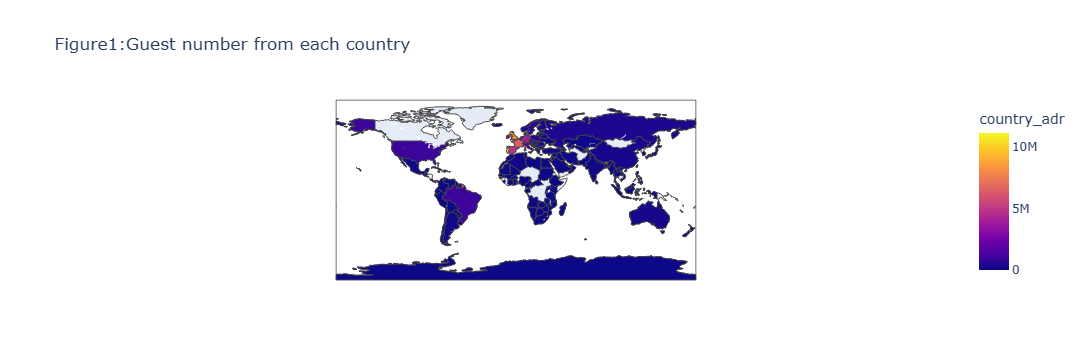

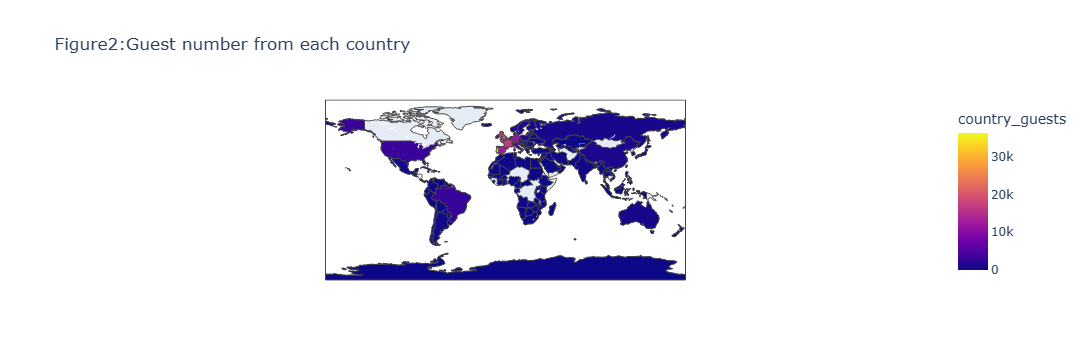

In [11]:
figure_count=1

from folium.plugins import HeatMap
basemap = folium.Map()
adrs_map = px.choropleth(adr_country, locations = adr_country['country'],
                        color = adr_country['country_adr'], hover_name =adr_country['country'] , 
                        title= 'Figure'+ str(figure_count)+":" + "Guest number from each country", 
                        ) 
adrs_map.show()


figure_count+=1
guests_map = px.choropleth(adr_country, locations = adr_country['country'],
                        color = adr_country['country_guests'], hover_name = adr_country['country'],
                        title= 'Figure'+ str(figure_count) +":" + "Guest number from each country"
                          ) 
guests_map.show()

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
Through the following charts give us some results which although the charts are representetive , we enumerated the results here too:

<li>    
Figure 3: Near 2/3 of canceled reservations is due to the "PRT" country.
<li>
Figure 4: Near half of successful reservations are due to the "PRT" and "GBR" coutries. Totally, PRT and "GBR" have near 1/3 and near 1/6 of successful reservations respectively.
<li>
Figure 5: 2/3 of successful reservations belong to "City Hotel" and 1/3 for "Rosert Hotel"
<li>
Figure 6: Near half successful reservations are done online.
<li>
Figure 7: 3/4 of successful reservations are reserved through agents either online of face to face.
<li>
Figure 8: In near 3/4 of successful reservations, customer type is 'Transit'.
<li>
Figure 9: More than 3/4 of successful reservations have chosen meal type 'BB'
<li>
Figure 10: 58% of reservations in "city Hotel" are successfull while this rate is 72% in "Rosert Hotel". It means that according to the result of Figure 4, in total travels of both hotels, Rosert hotel has less share of reservation and therefore less successfull reservations share. But according to Figure 10, if a guest choose Rosert hotel, the probobility of cancelations is less.
<li>
Figure 11: Price fluctuations in Hotel 1 are more stable over time.
<li>
Figure 12: The pairs of figures in figure 12 show the bookings of each of the two hotels in different months of the year, separately from canceled and non-cancelled. It is clear that the number of reservations of Rosert hotel is less than that of City Hotel.
<li>
Figure 13: This figure is the same as Figure 12 except that it is only due to the successful reservations.




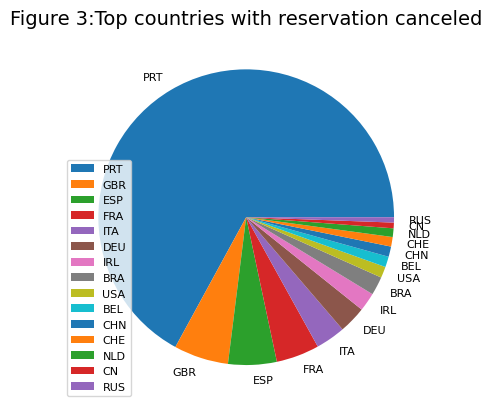

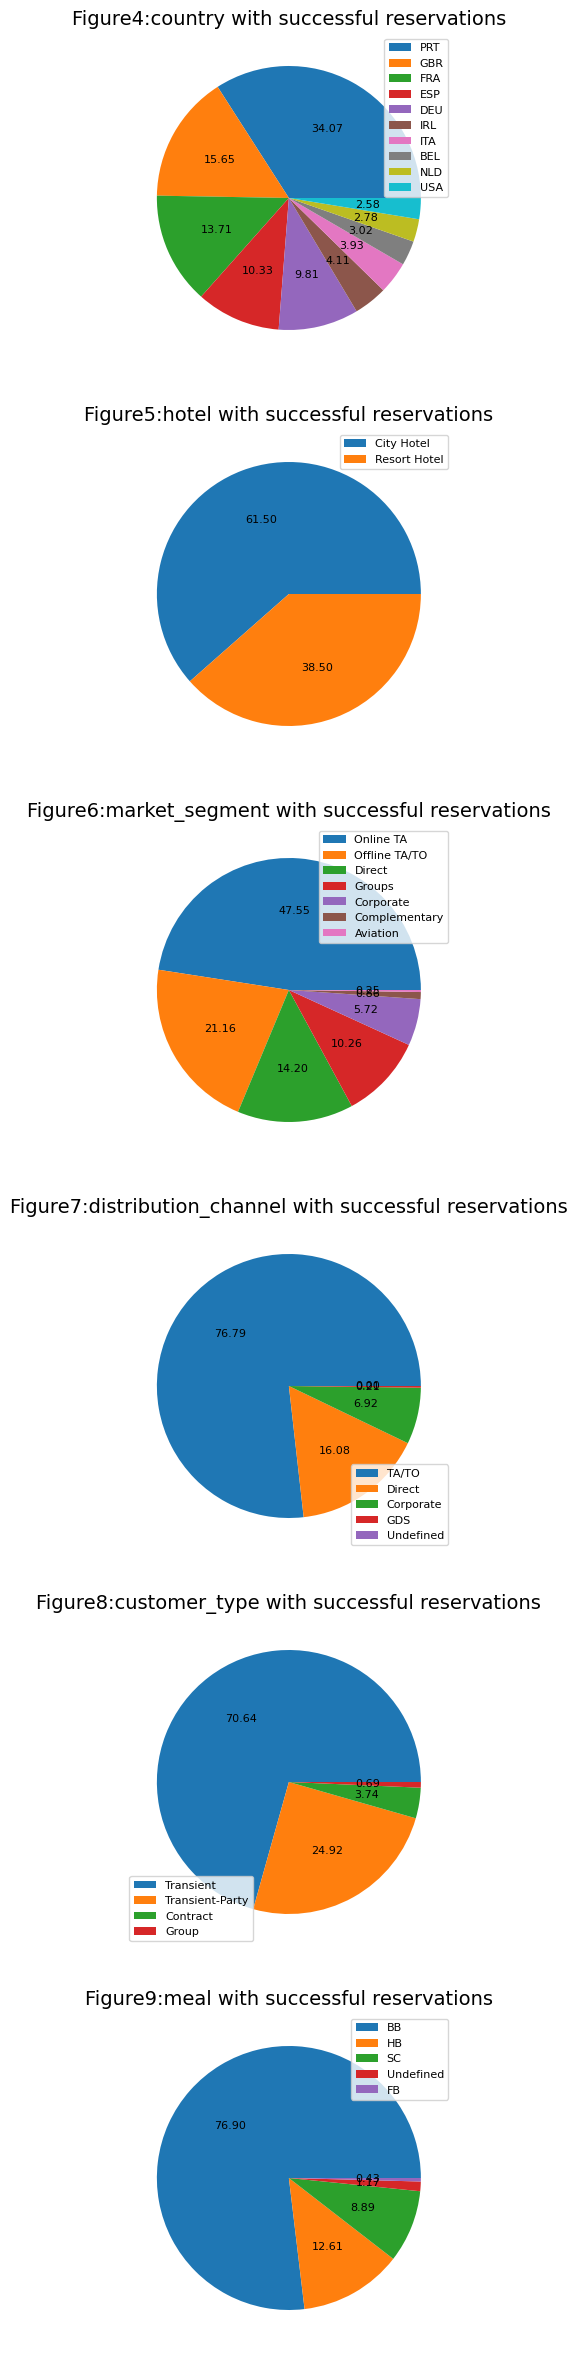

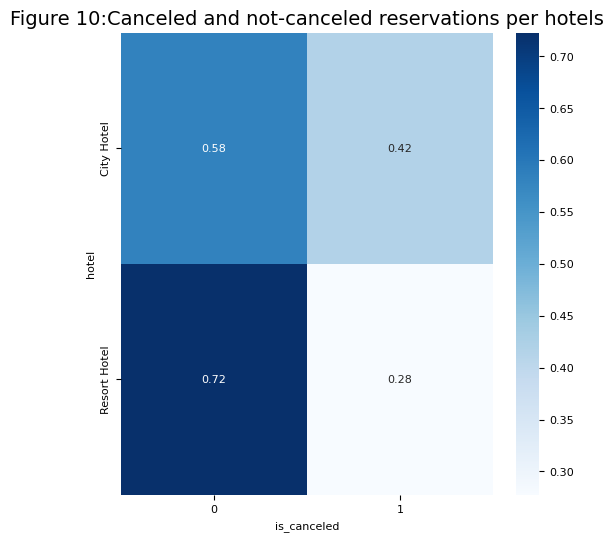

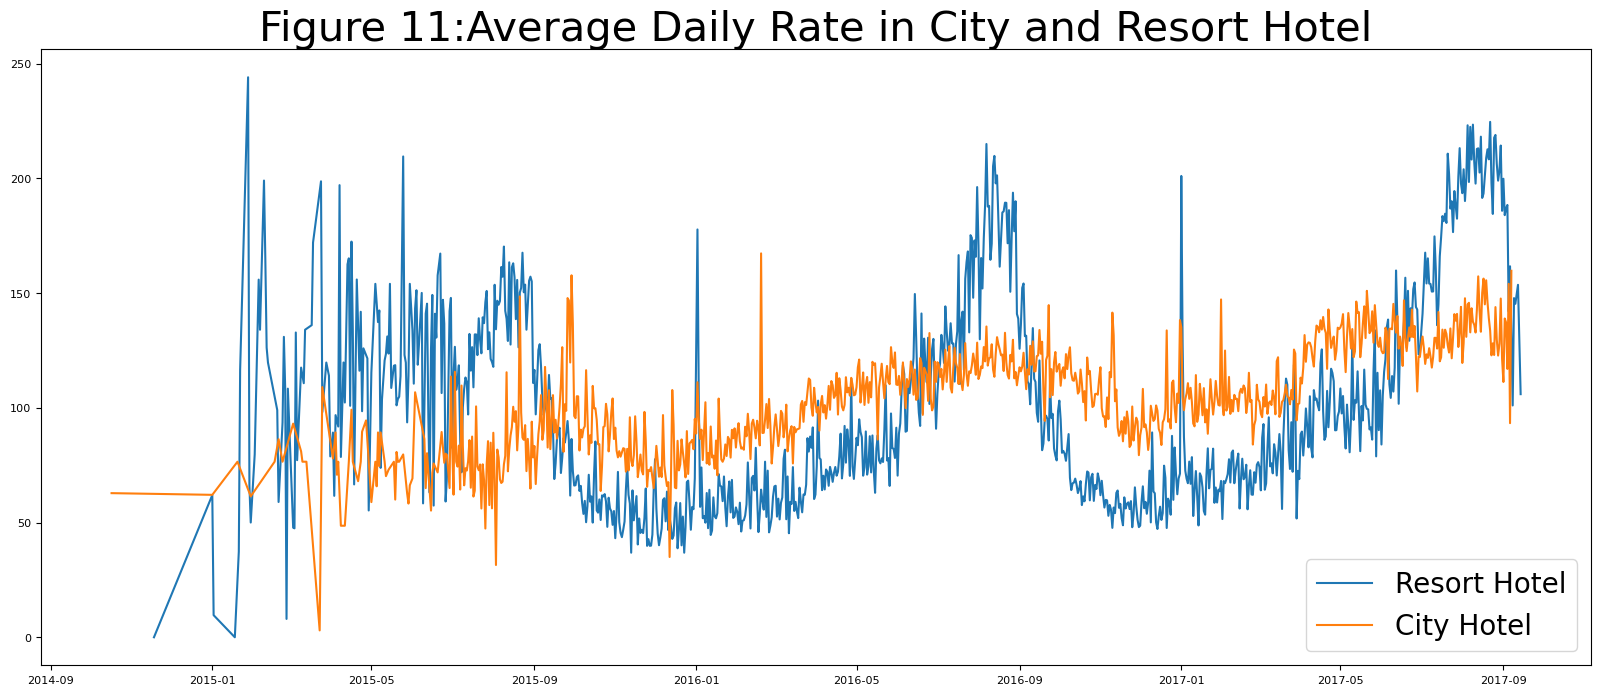

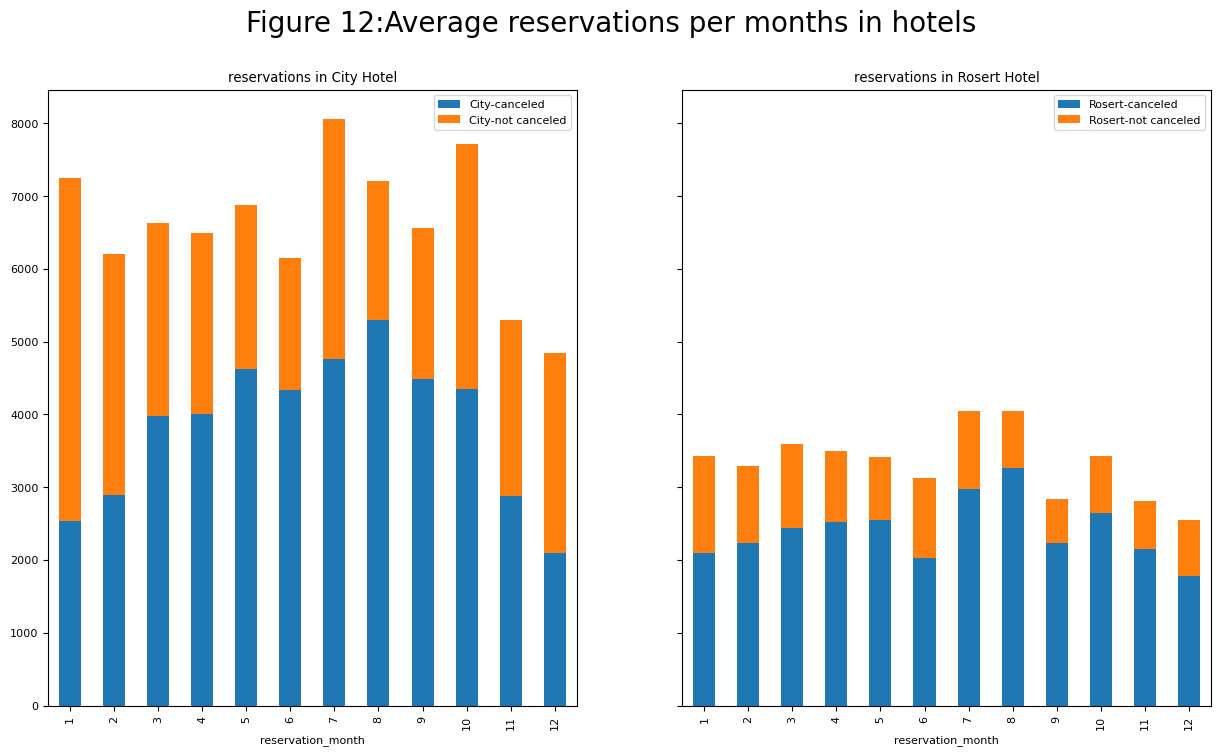

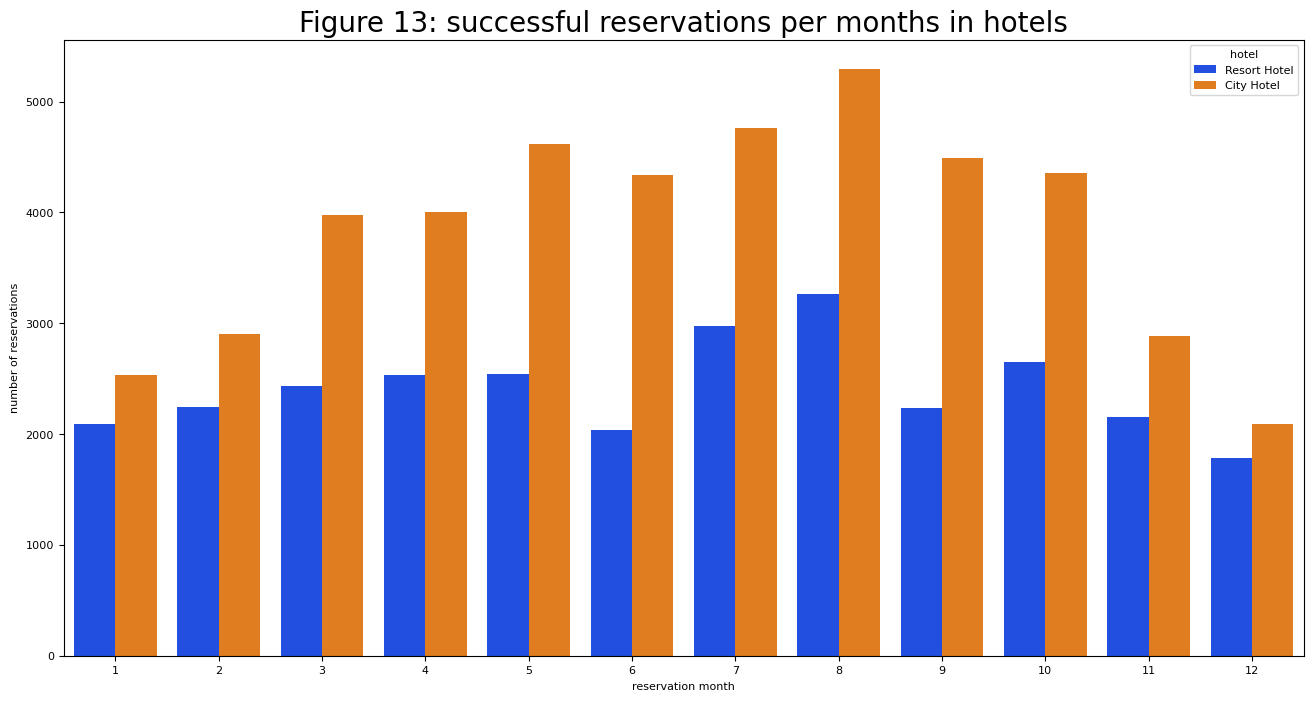

In [12]:
figure_count+=1
plt.rc('font', size=8)
cancelled_data = df[df['is_canceled'] == 1]
top_15_country = cancelled_data ['country'].value_counts()[:15] 
plt.figsize = (5,5)
plt.title('Figure '+str(figure_count)+':'+'Top countries with reservation canceled',fontsize = 14 )
plt.pie(top_15_country ,labels =top_15_country.index )
plt.legend()
plt.show();
print()

########################################################################################################
print()
uncancelled_data = df[df['is_canceled'] == 0]
temp=['country' ,'hotel', 'market_segment', 'distribution_channel', 'customer_type',  'meal']
fig,axis = plt.subplots(len(temp) ,1 , figsize = (20,30))
for i ,col in enumerate(temp):
    figure_count+=1
    top_10 = uncancelled_data [col].value_counts() [:10] 
    axis[i].set_title('Figure'+ str(figure_count) +":"+col+' with successful reservations'  ,{'fontsize': 14})
    axis[i].pie(top_10 ,autopct = '%.2f'  ) 
    axis[i].legend(labels = top_10.index)
plt.show();
########################################################################################################
print()
figure_count+=1
cancelled_perc = df.groupby('hotel') ['is_canceled'].value_counts(normalize = True).to_frame() 
cancelled_perc.rename(columns = {'is_canceled':'percent'}, inplace = True)
cancelled_perc.reset_index() 
plt.figure(figsize = (6,6))
sns.heatmap(cancelled_perc.pivot_table(index='hotel',columns='is_canceled', values='percent'), annot=True, cmap='Blues') 
plt.title('Figure '+str(figure_count)+':'+'Canceled and not-canceled reservations per hotels' ,fontsize = 14)
plt.show()

#########################################################################################################
print()
figure_count+=1
adrs = df.groupby(['hotel','reservation_status_date'])['adr'].mean().to_frame().reset_index()
roserthotel=adrs.loc[adrs.hotel=='Resort Hotel']
cityhotel=adrs.loc[adrs.hotel=='City Hotel']
plt.figure(figsize = (20,8))
plt.title('Figure '+str(figure_count)+':'+'Average Daily Rate in City and Resort Hotel', fontsize = 30)
plt.plot(roserthotel.reservation_status_date , roserthotel['adr'], label = 'Resort Hotel')
plt.plot(cityhotel.reservation_status_date, cityhotel['adr'], label = 'City Hotel')
plt.legend(fontsize = 20)
plt.show()
 
########################################################################################################
print()
figure_count+=1
d=df[['reservation_month','hotel','is_canceled']]
d=d.groupby(['reservation_month','hotel','is_canceled'])[['reservation_month','hotel','is_canceled']].value_counts()
d=d.to_frame().reset_index()
d.columns=['reservation_month','hotel','is_canceled','count']
d=d.pivot(index='reservation_month', columns=['hotel', 'is_canceled'], values='count').reset_index() 
d=d.set_index('reservation_month')
 
fig,ax=plt.subplots(1,2,figsize=(15, 8) ,sharey=True) 
d[[( 'City Hotel', 0),('City Hotel', 1)]] .plot(kind='bar' , stacked=True , ax=ax[0] )
ax[0].set_title("reservations in City Hotel")
ax[0].legend(['City-canceled','City-not canceled'])
d[[('Resort Hotel', 0), ('Resort Hotel', 1)]].plot(kind='bar' , stacked=True , ax=ax[1] ) 
ax[1].set_title("reservations in Rosert Hotel")
ax[1].legend(['Rosert-canceled','Rosert-not canceled'])
plt.suptitle('Figure '+str(figure_count)+':'+'Average reservations per months in hotels',size = 20)
plt.show()

########################################################################################################
print()
figure_count+=1
plt.figure(figsize = (16,8))
ax1 = sns.countplot(x = 'reservation_month',hue = 'hotel',data = df[df['is_canceled'] == 0], palette = 'bright') 
plt.title('Figure '+str(figure_count)+':'+' successful reservations per months in hotels',size = 20)
plt.xlabel('reservation month')
plt.ylabel('number of reservations') 
plt.show()




<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
Now we plotted the charts and do not need descriptive strings in our features. Instaed we want their numerical value for the use in our model. Hence we do one_hot_encoding for the rest categorical features and our data will be all numerical to be ready for applying ML models on it.

In [13]:
 

data=df[[*cat_cols, *numeric_cols]]  
 
data = pd.get_dummies(data, columns=cat_cols)
new_columns={}
for c in data.columns:
    new_columns[c]=c.replace(' ', '_')
data.rename(columns=new_columns, inplace=True)


In [14]:

columns_status(data)

feature Nones nunique   min          max  \
0                              adr     0    8879 -6.38       5400.0   
1                           adults     0      14     0           55   
2        arrival_date_day_of_month     0      31     1           31   
3               arrival_date_month     0      12     1           12   
4         arrival_date_week_number     0      53     1           53   
5                arrival_date_year     0       3  2015         2017   
6                           babies     0       5     0           10   
7                  booking_changes     0      21     0           21   
8                         children     0       5   0.0         10.0   
9             days_in_waiting_list     0     128     0          391   
10                     is_canceled     0       2     0            1   
11               is_repeated_guest     0       2     0            1   
12                       lead_time     0     479     0          737   
13  previous_bookings_not_canceled     0      73     0           72   
14          previous_cancellations     0      15     0           26   
15     required_car_parking_spaces     0       5     0            8   
16        reservation_day_of_month     0      31     1           31   
17               reservation_month     0      12     1           12   
18                reservation_year     0       4  2014         2017   
19            stays_in_week_nights     0      35     0           50   
20         stays_in_weekend_nights     0      17     0           19   
21       total_of_special_requests     0       6     0            5   
22                     country_adr     0     164  88.0  11183648.78   
23                  country_guests     0     108   1.0      36409.9   
24                hotel_City_Hotel     0       2     0            1   
25              hotel_Resort_Hotel     0       2     0            1   
26                         meal_BB     0       2     0            1   
27                         meal_FB     0       2     0            1   
28                         meal_HB     0       2     0            1   
29                         meal_SC     0       2     0            1   
30                  meal_Undefined     0       2     0            1   
31         market_segment_Aviation     0       2     0            1   
32    market_segment_Complementary     0       2     0            1   
33        market_segment_Corporate     0       2     0            1   
34           market_segment_Direct     0       2     0            1   
35           market_segment_Groups     0       2     0            1   
36    market_segment_Offline_TA/TO     0       2     0            1   
37        market_segment_Online_TA     0       2     0            1   
38        market_segment_Undefined     0       2     0            1   
39  distribution_channel_Corporate     0       2     0            1   
40     distribution_channel_Direct     0       2     0            1   
41        distribution_channel_GDS     0       2     0            1   
42      distribution_channel_TA/TO     0       2     0            1   
43  distribution_channel_Undefined     0       2     0            1   
44          customer_type_Contract     0       2     0            1   
45             customer_type_Group     0       2     0            1   
46         customer_type_Transient     0       2     0            1   
47   customer_type_Transient-Party     0       2     0            1   

                                         UniqueValues  
0   [0.0, 107.0, 103.0, 82.0, 105.5, 123.0, 145.0,...  
1   [2, 3, 1, 4, 40, 26, 50, 27, 55, 0, 20, 6, 5, 10]  
2   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
3             [7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6]  
4   [27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 3...  
5                                  [2015, 2016, 2017]  
6                                    [0, 1, 2, 10, 9]  
7   [3, 4, 0, 1, 2, 5, 6, 8, 7, 10, 20, 15, 21, 14...  
8                          [0.0, 2.0, 1.0, 

# Feature selection for models


<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
As we know, some ML models are time-consuming when we have lots of features. Therfore we should prioritize features in order to include them as predictive key features. For example in this case study, SVM or SVC models are too time-consuming to work with high number of features.

In order to solve this problem, we can investigate the corrolation of the features with each other and also with the target feature. The following charts show these corrolations via heatmaps. It is considerable to note that we ignored weak corrolations (i.e. those corrolations between thersholds -10% and 10%). 
Highly corrolated fatures are also shown through the bar chart in the following.



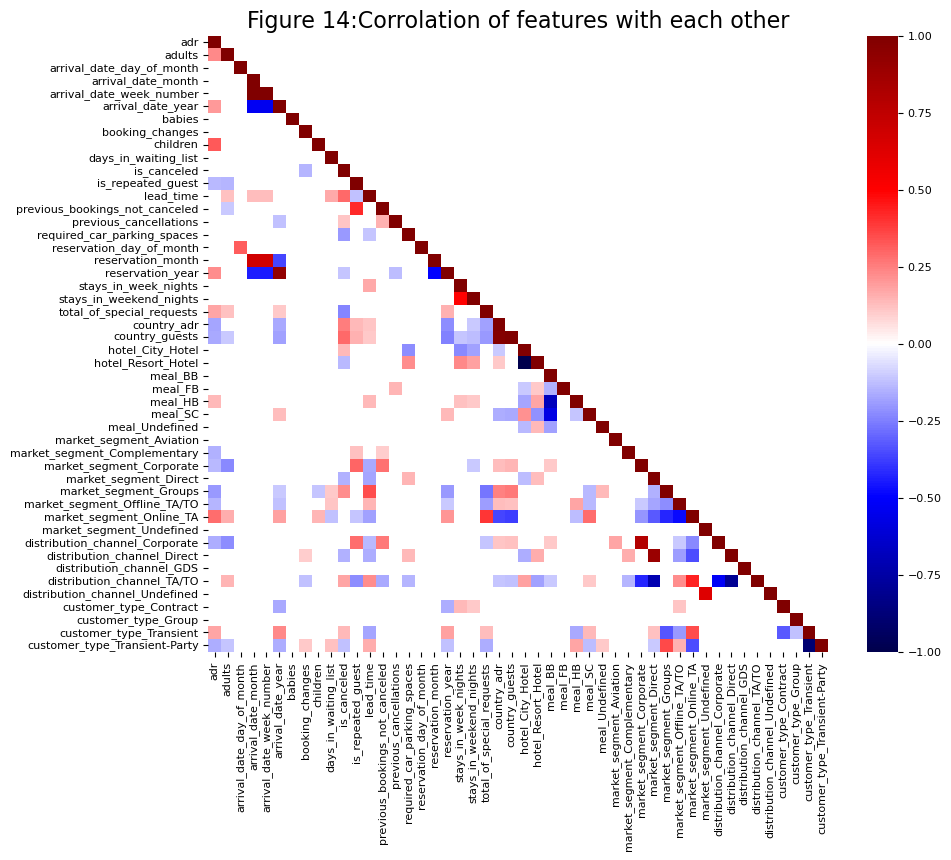

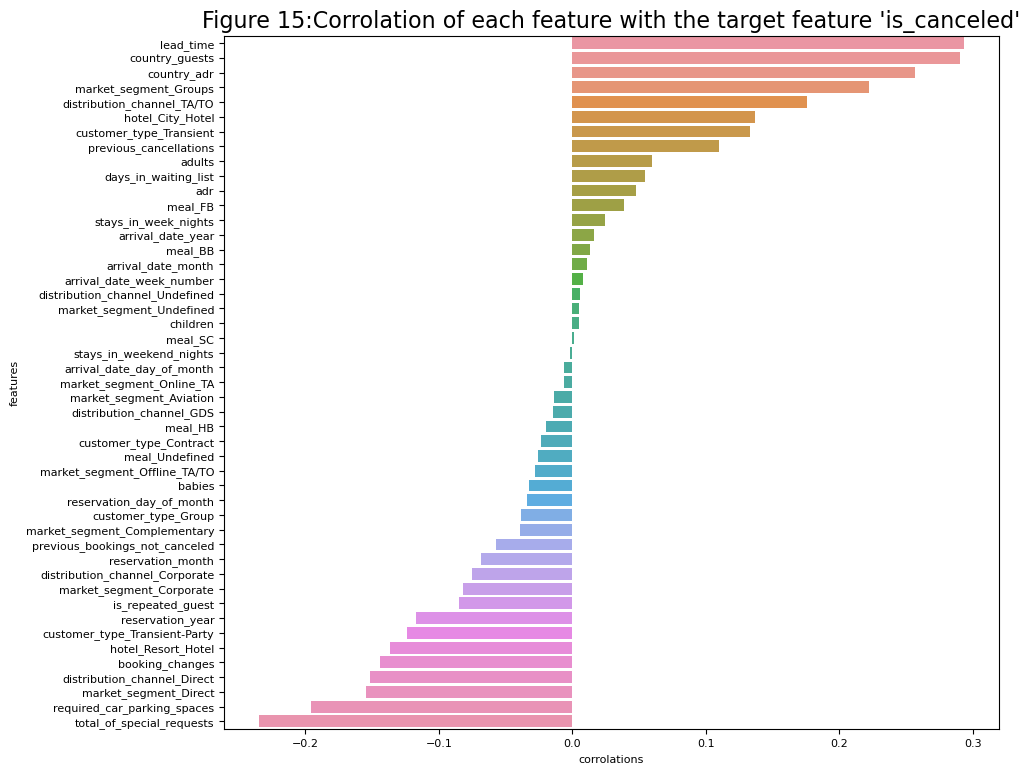

In [15]:
figure_count+=1
corr=data.corr()['is_canceled'].sort_values(ascending=False).to_frame()
corr.reset_index(inplace=True)
corr.columns=['features','corrolations']
corr_thershold=data.corr() 
triangular_thershold_corr =corr_thershold.copy()
for i in range (len(triangular_thershold_corr)):
    for j in range (len(triangular_thershold_corr)):
        if i<j :
            triangular_thershold_corr.iloc[i,j]=np.nan
triangular_thershold_corr =triangular_thershold_corr[(triangular_thershold_corr>0.1 )| (triangular_thershold_corr<-0.1)]


fig,ax= plt.subplots(figsize=(10,8) )
sns.heatmap(triangular_thershold_corr, annot=False , cmap='seismic' , fmt='.2f' , ax=ax )
plt.title('Figure '+str(figure_count)+':'+"Corrolation of features with each other" ,{'fontsize': 16})
plt.show()

figure_count+=1
fig,ax= plt.subplots(figsize=(10,9) )
corrs_with_target=corr.iloc[1:,:]
sns.barplot(data=corrs_with_target , y='features' ,x='corrolations' ,ax=ax)
plt.title('Figure '+str(figure_count)+':'+"Corrolation of each feature with the target feature 'is_canceled'" ,{'fontsize': 16} )
plt.show();


<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
As depicted in above figure (i.e. Figure 16) we can recognized important features based on the corrolation of the features with the target.Hence, we ignore the features in the middle of the above barchart and only deal with important features for algorithms like SVC. 

In [16]:
thershold=0.1
important_features=list(corrs_with_target.loc[np.abs(corrs_with_target['corrolations'])>thershold].features)
important_features

['lead_time',
 'country_guests',
 'country_adr',
 'market_segment_Groups',
 'distribution_channel_TA/TO',
 'hotel_City_Hotel',
 'customer_type_Transient',
 'previous_cancellations',
 'reservation_year',
 'customer_type_Transient-Party',
 'hotel_Resort_Hotel',
 'booking_changes',
 'distribution_channel_Direct',
 'market_segment_Direct',
 'required_car_parking_spaces',
 'total_of_special_requests']

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
In the next step we refine the above 16 features so that among these important features, features with high correlation with others are ignored. (i.e. If there is a high correlation between two or more important features, one of them is sufficient and the rest are superfluous.). First, let's see the heatmap of corrolations among these 16 features:

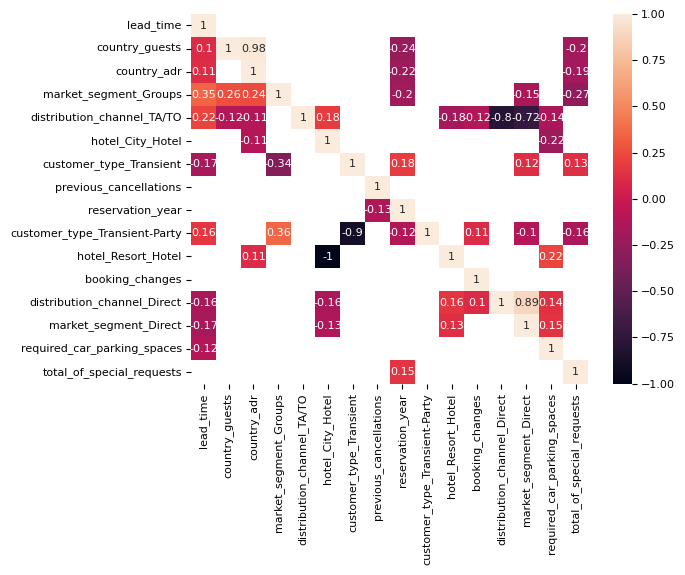

In [17]:
corr_of_impartants = triangular_thershold_corr.loc[important_features ,important_features]
sns.heatmap(corr_of_impartants , annot=True)
plt.show()

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
<p>
    Here we see pairs of features which are highly correlated. We ignore the second item in each pair has more correlations with other features too:
</p>
<table>
    <tr style="background-color: #1affb3;"> 
        <th>First Column</th>
        <th>Second Column</th>
    </tr>
    <tr style="background-color: #1affb3;"> 
        <td>'lead_time'</td>
        <td>'market_segment_Groups'</td>
    </tr>
    <tr style="background-color: #1affb3;"> 
        <td>'country_adr'</td>
        <td>'country_guests'</td>
    </tr>
    <tr style="background-color: #1affb3;"> 
        <td>'customer_type_Transient'</td>
        <td>'market_segment_Groups'</td>
    </tr>
    <tr style="background-color: #1affb3;">
        <td>'hotel_City_Hotel'</td>
        <td>'hotel_Resort_Hotel'</td>
    </tr>
    <tr style="background-color: #1affb3;"> 
        <td>'customer_type_Transient'</td>
        <td>'customer_type_Transient-Party'</td>
    </tr>
    <tr style="background-color: #1affb3;"> 
        <td>'market_segment_Direct'</td>
        <td>'distribution_channel_Direct'</td>
    </tr>
    <tr style="background-color: #1affb3;"> 
        <td>'distribution_channel_TA/TO'</td>
        <td>'distribution_channel_Direct'</td>
    </tr>
    <tr style="background-color: #1affb3;"> 
        <td>'distribution_channel_TA/TO'</td>
        <td>'market_segment_Direct'</td>
    </tr> 
</table>  
</div>

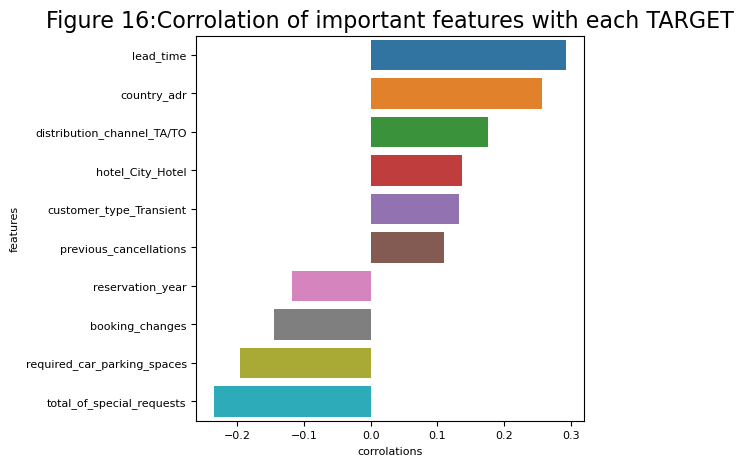

In [18]:


important_features = ['lead_time',
 'country_adr', 
 'customer_type_Transient',
 'previous_cancellations',
 'reservation_year', 
 'hotel_City_Hotel',
 'booking_changes', 
 'distribution_channel_TA/TO',
 'required_car_parking_spaces',
 'total_of_special_requests'] 
figure_count+=1 
fig,ax= plt.subplots(figsize=(5,5) ) 
sns.barplot(data=corrs_with_target.loc[corrs_with_target.features.isin(important_features)] , y='features' ,x='corrolations' ,ax=ax)
plt.title('Figure '+str(figure_count)+':'+"Corrolation of important features with each TARGET" ,{'fontsize': 16} )
plt.show();

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
In the last refinement, we ignore two of middle features (with less corrolation) in the bar chart above so that only 8 features remain to include in SVC model. 
As we will see, the result of the XGboost classifier also gives us a list of important features which is highly similar to the following list of features:

In [19]:
important_features= ['lead_time',
 'country_adr', 
 'customer_type_Transient',  
 'hotel_City_Hotel',
 'booking_changes', 
 'distribution_channel_TA/TO',
 'required_car_parking_spaces',
 'total_of_special_requests'] 

# Modeling

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
First of all, the data set is devided into the train and test parts and then the pipelines are constructed for our considered models i.e. XGBoost, Random-forest, Decision tree, KNN and SVC models. The scaler used for the model is the Standard scaler. The hyper_parameters are tuned as follows. For the purpose of easy access to the defined model and better demonstration of them, they are stored in a dataframe called 'models_dataframe':

In [20]:
 
from sklearn.model_selection import train_test_split

y=np.ravel(data['is_canceled']) 
X=data.drop('is_canceled' , axis=1)
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.35, random_state=123) 

In [21]:


models_dataframe = pd.DataFrame({'pipline':[] , 'param_grid':[]})
#models_dataframe.set_index('model')

models_dataframe.loc['xgb' ] =  [Pipeline([('scaler' ,StandardScaler()), ('clf', xgb.XGBClassifier(random_state=123))])
                                 ,{'clf__n_estimators':[150] 
                                  }
                                ] 

models_dataframe.loc['rforest' ] = [Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier())] )
                                     ,{'clf__n_estimators':[100,150],
                                      'clf__criterion':['gini', 'entropy', 'log_loss']
                                       }
                                   ]


models_dataframe.loc['dtree' ] = [Pipeline([('scaler', StandardScaler()), ('clf', DecisionTreeClassifier())] )
                                  , {'clf__criterion':['gini', 'entropy', 'log_loss'] }
                                 ]


models_dataframe.loc['knn']  = [ Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())] )
                                ,{'clf__n_neighbors': [5,15,30], 
                                  #'clf__weights': ['uniform', 'distance']
                                  }
                               ]


models_dataframe.loc['svc_standard']=[ Pipeline([# 'preprocessor' considers only 'important_features' in SVC and drops other feature
                                                 #by using a ColumnTransformer
                                                ('preprocessor' ,ColumnTransformer(transformers=[("scaler", StandardScaler(), important_features)]
                                                                                   ,remainder='drop'
                                                                                  )
                                                 ),
                                                ('clf', SVC())
                                                ]) 
                                      ,{#'clf__C': [0.5, 1 ,5 ],
                                       'clf__kernel': ['linear','sigmoid' ,'poly', 'rbf'],
                                       'clf__degree':[1,2,3] }
                                     ]
 
models_dataframe

pipline  \
xgb           (StandardScaler(), XGBClassifier(base_score=No...   
rforest            (StandardScaler(), RandomForestClassifier())   
dtree              (StandardScaler(), DecisionTreeClassifier())   
knn                  (StandardScaler(), KNeighborsClassifier())   
svc_standard  (ColumnTransformer(transformers=[('scaler', St...   

                                                     param_grid  
xgb                                {'clf__n_estimators': [150]}  
rforest       {'clf__n_estimators': [100, 150], 'clf__criter...  
dtree         {'clf__criterion': ['gini', 'entropy', 'log_lo...  
knn                           {'clf__n_neighbors': [5, 15, 30]}  
svc_standard  {'clf__kernel': ['linear', 'sigmoid', 'poly', ...

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
Finally, in "for" loops, we feed each model's pipline within its hyperparameters to the gridSearch. The results of each model are stored in a row of a dataframe called "gridsearch_results" for the easy access. This dataframe holds these information for each model: 'model', 'best_score', 'prediction_accuracy', prediction_f1_accuracy', 'best_params', 'best_estimator'.

It is considerable that the SVC model is too much time-consuming. Hence we reduced its dealing features to include only "important features" that mentioned before. Although we did that it still takes about an hour long to run. Please be patient when you run the following cell! (if you want to skip SVC, just delete "#" sign before the comment "#if model!='svc_standard':" in the following cell):

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
As we see the most accurate model is XGBoost with more than 99.8% accuracy. The worst accurate model is SVC (and also most time consuming model).

In [23]:
gridsearch_results

model  best_score  prediction_accuracy  prediction_f1_accuracy  \
0           xgb    0.997081             0.998540                0.998033   
1       rforest    0.918273             0.951817                0.932429   
2         dtree    0.919326             0.947963                0.929930   
3           knn    0.834291             0.894849                0.849105   
4  svc_standard    0.699190             0.795706                0.700221   

                                         best_params  \
0                         {'clf__n_estimators': 150}   
1  {'clf__criterion': 'log_loss', 'clf__n_estimat...   
2                     {'clf__criterion': 'log_loss'}   
3                            {'clf__n_neighbors': 5}   
4           {'clf__degree': 1, 'clf__kernel': 'rbf'}   

                                      best_estimator  
0  (StandardScaler(), XGBClassifier(base_score=No...  
1  (StandardScaler(), (DecisionTreeClassifier(cri...  
2  (StandardScaler(), DecisionTreeClassifier(crit...  
3         (StandardScaler(), KNeighborsClassifier())  
4  (ColumnTransformer(transformers=[('scaler', St...

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
Now we have easy access to see the optimal parameters for each model (e.g. the optimal hyperparameters of decision tree is reported below.):

In [24]:
gridsearch_results.iloc[2,4]

{'clf__criterion': 'log_loss'}

In [25]:

# Save the resultant DataFrame to a file
with open("gridsearch_results.pkl", "wb") as gr:
    pickle.dump(gridsearch_results, gr)
    
with open("X_test.pkl", "wb") as xtst:
    pickle.dump(X_test, xtst)
with open("y_test.pkl", "wb") as ytst:
    pickle.dump(y_test, ytst)
    
with open("X_train.pkl", "wb") as xtrn:
    pickle.dump(X_train, xtrn)
with open("y_train.pkl", "wb") as ytrn:
    pickle.dump(y_train, ytrn)

<div style="border-radius:10px; padding: 15px; background-color: #1affb3; font-size:120%; text-align:left">
Now let's re-run XGBoost with its optimal hyperparameters again to see more results from that. As we see in the following chart, XGBoost resulted the feature importance which approximately coincides with our results of "important_features" described in the feature selection section.

In [26]:
with open("gridsearch_results.pkl", "rb") as gr:
    gridsearch_results = pickle.load(gr)
    
with open("X_test.pkl", "rb") as xtst:
    X_test=pickle.load(xtst)
with open("y_test.pkl", "rb") as ytst:
    y_test=pickle.load(ytst)
    
with open("X_train.pkl", "rb") as Xtrn:
    X_trn=pickle.load(Xtrn)
with open("y_train.pkl", "rb") as ytrn:
    y_trn=pickle.load(ytrn)

{'clf__n_estimators': 150}
[18:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "clf__n_estimators" } are not used.



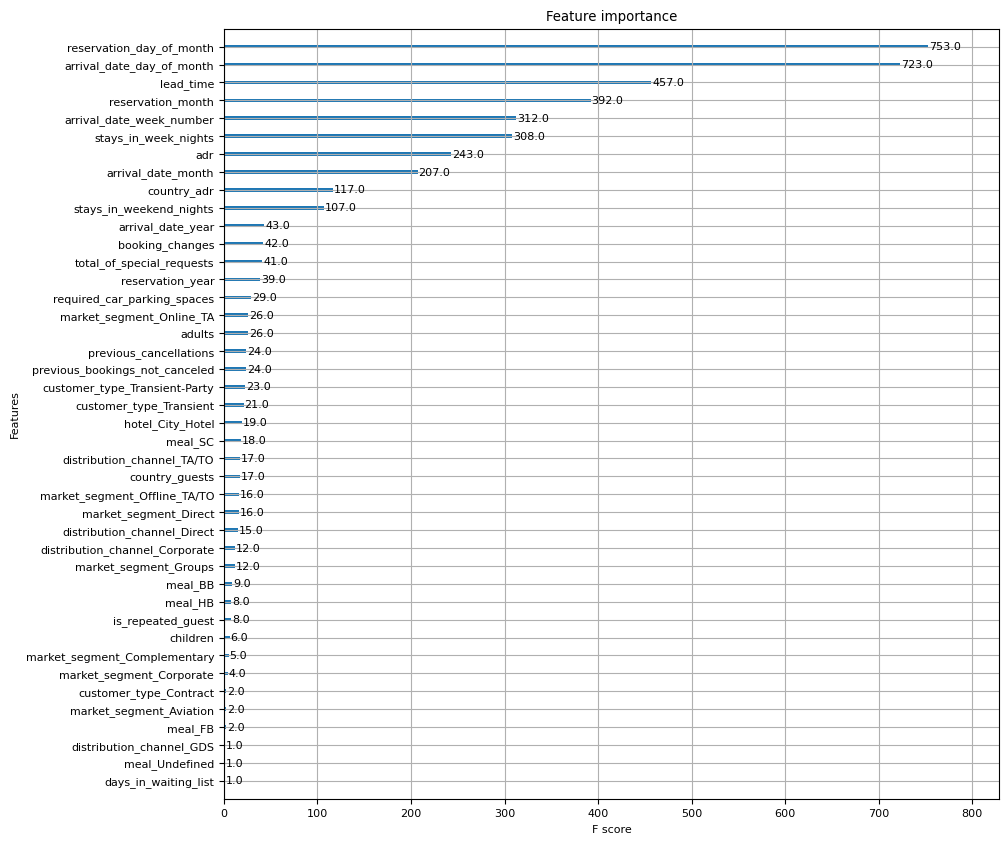

In [27]:
params=gridsearch_results.iloc[0,4]
print(params)
optimal_xgb_clf= xgb.XGBClassifier()
optimal_xgb_clf.set_params(**params)

fig , ax=plt.subplots(figsize=(10,10))
optimal_xgb_clf.fit(X_train, y_train)
xgb.plot_importance(optimal_xgb_clf , ax=ax);
plt.show();


xgb.plot_tree(optimal_xgb_clf, max_depth=3)
plt.show()

In [28]:
#Fatemeh Boloori